In [1]:
from pathlib import Path 
from torchvision.io import read_image
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as VF
from torchvision.utils import make_grid
from PIL import Image 
import os 

rlpath = Path("../data/real_faces").absolute()
ckpath = Path("../data/ck_faces").absolute()
DEVICE = "cpu"

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img, mode="RGB")
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def read_images(paths: list[str | Path], extension: str | None=None) -> list[Image]:
    images = []
    for path in paths:
        fname = f"{path}.{extension}" if extension else str(path)
        img = Image.open(fname)
        images.append(img)
    return images

def get_fnames_without_extension(directory_path: Path):
    file_names = []

    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)):
            name, extension = os.path.splitext(filename)
            if name[0] != ".":
                file_names.append(name)
    
    return file_names


# Faces

In [3]:
names = get_fnames_without_extension(rlpath)
rl_images_paths = [rlpath / name for name in names]
ck_images_paths = [ckpath / name for name in names]

ck_images = read_images(list(ck_images_paths), "png")
rl_images = read_images(list(rl_images_paths), "jpeg")

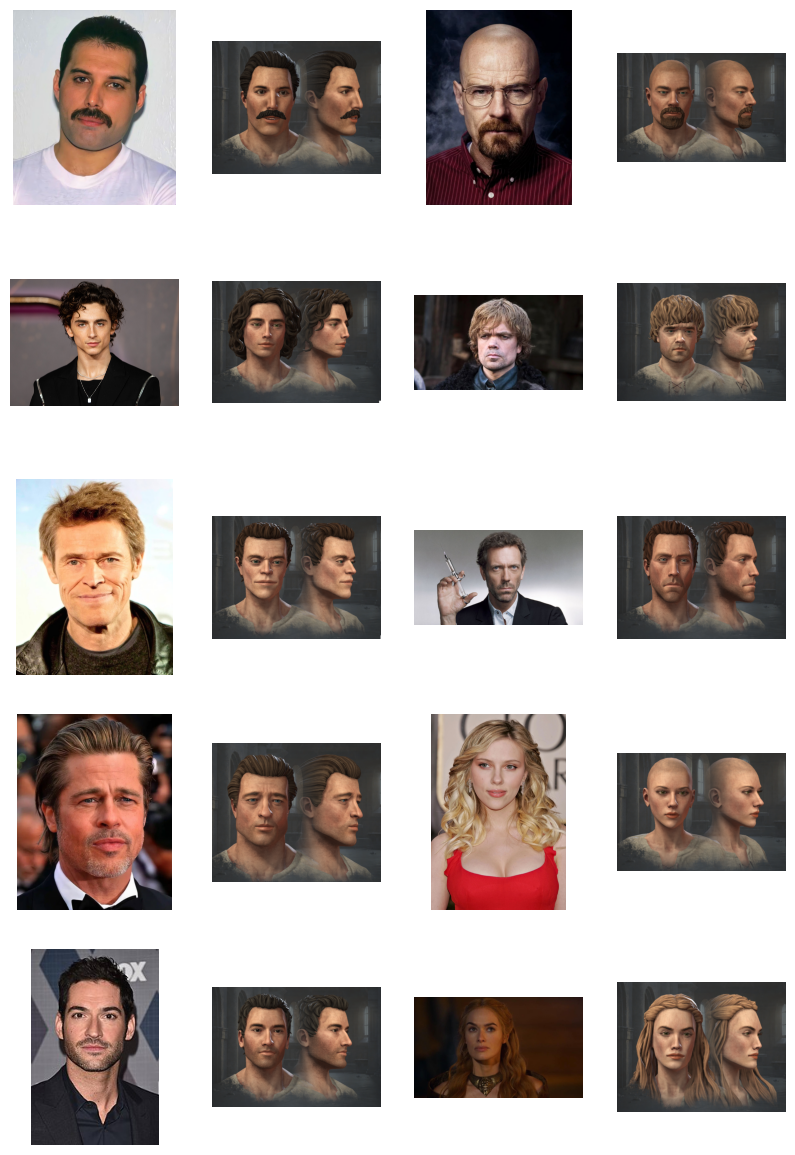

In [4]:
plt.figure(figsize=(10, 30))
for i, (rl_img, ck_img) in enumerate(zip(rl_images, ck_images)):
    plt.subplot(len(names), 4, 2*i + 1)
    plt.axis("off")
    plt.imshow(rl_img)
    plt.subplot(len(names), 4, 2*i + 2)
    plt.axis("off")
    plt.imshow(ck_img)

# Preprocessing with MTCNN

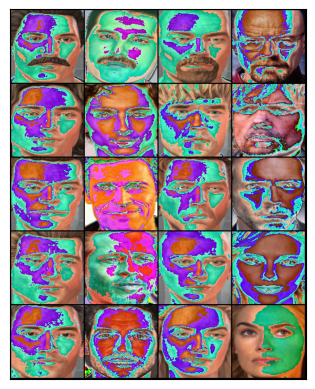

In [5]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import itertools as it 

IMAGE_SIZE = 128
MARGIN = 0

# extract faces from photos 
mtcnn = MTCNN(image_size=IMAGE_SIZE, margin=MARGIN, device=DEVICE, post_process=True)
ck_tensors = [mtcnn(img) for img in ck_images]
rl_tensors = [mtcnn(img) for img in rl_images]
show(make_grid(list(it.chain.from_iterable(list(zip(ck_tensors, rl_tensors)))), 4))

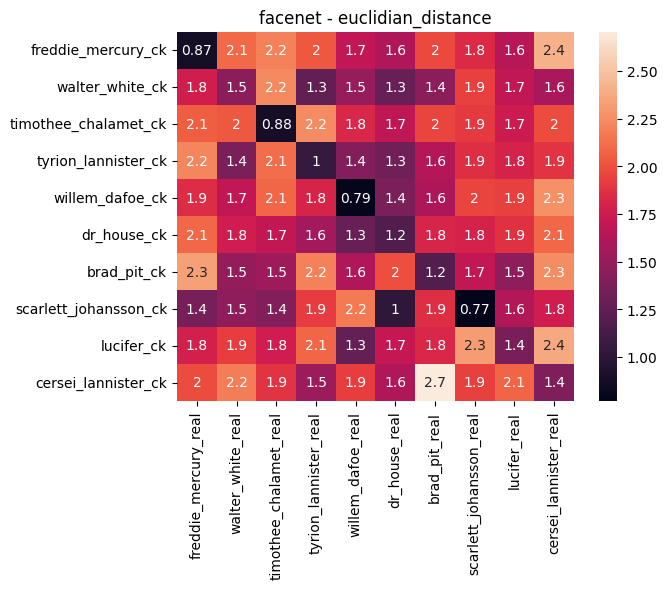

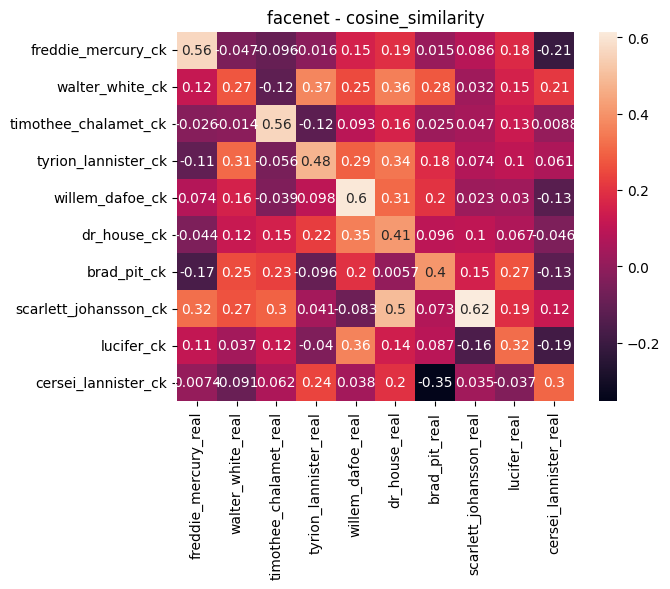

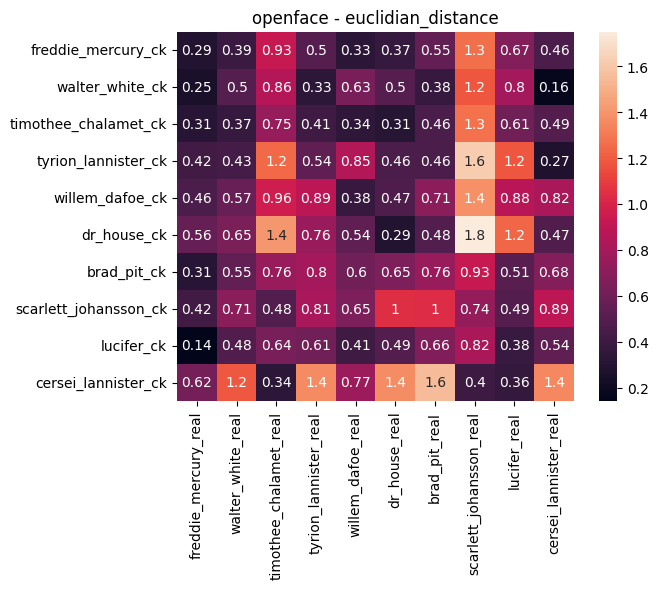

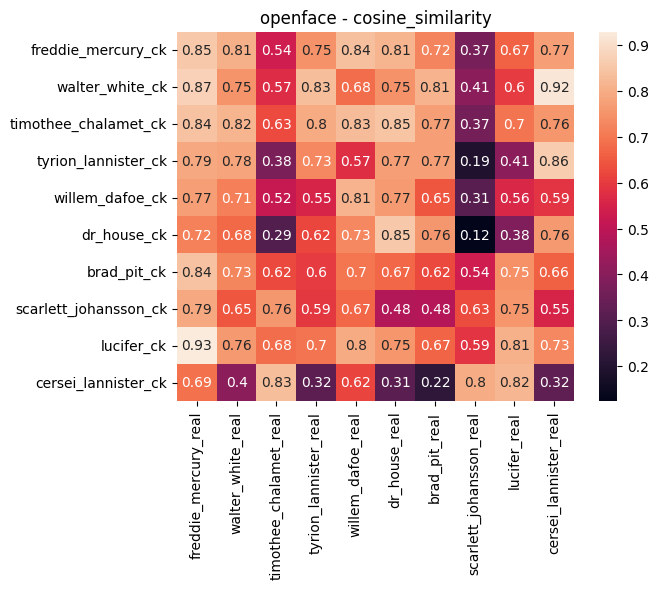

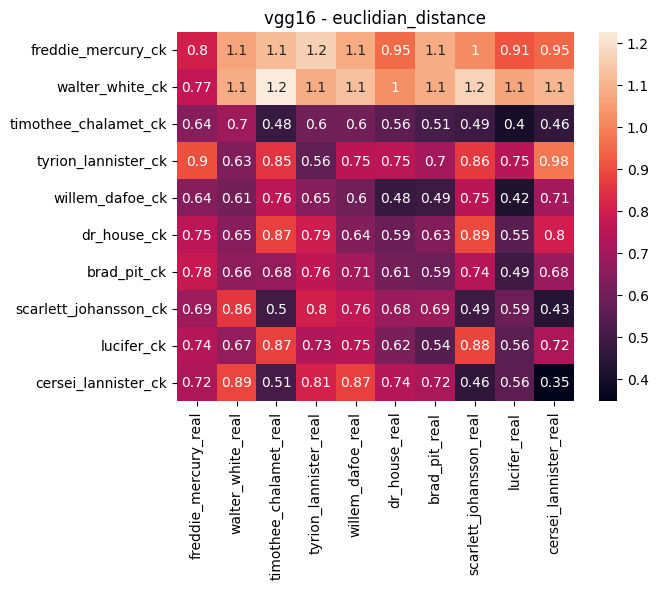

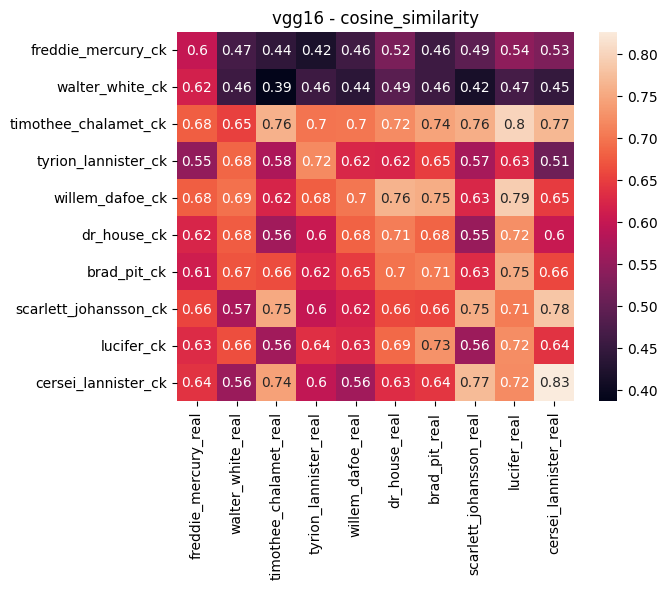

In [8]:
import seaborn as sns 
from models.openface import load_openface
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.io import read_image


def cosine_similarity(features1: th.Tensor, features2: th.Tensor) -> th.Tensor:
    """
    features1, features2: [#samples, #dims]
    """
    return features1 @ features2.t()


def euclidian_distance(features1: th.Tensor, features2: th.Tensor) -> th.Tensor:
    """
    features1, features2: [#samples, #dims]
    """
    return th.sum((features1.unsqueeze(0).permute(1, 0, 2) - features2.unsqueeze(0)) ** 2, dim=-1)


resnet = InceptionResnetV1(pretrained='vggface2', device=DEVICE).eval()
openface = load_openface(useCuda=False, weights="../weights/openface_cpu_weights.pth").eval()
vgg16 = torchvision.models.vgg16(pretrained=True).eval()

models = [resnet, lambda x: openface(x)[0], lambda x: vgg16.avgpool(vgg16.features(x)).flatten(start_dim=1)]
model_name = ["facenet", "openface", "vgg16"]
metrics = [euclidian_distance, cosine_similarity]

for model, name in zip(models, model_name):
    with th.no_grad():
        ck_features = F.normalize(model(th.stack(ck_tensors)), p=2., dim=-1)
        rl_features = F.normalize(model(th.stack(rl_tensors)), p=2., dim=-1)
    for metric in metrics:
        result = metric(ck_features, rl_features)
        plt.title(f"{name} - {metric.__name__}")
        real_names = [n + "_real" for n in names]
        ck_names = [n + "_ck" for n in names]
        sns.heatmap(result.numpy(), annot=True, xticklabels=real_names, yticklabels=ck_names)
        plt.show()
